# MO-444 / Trabalho 2 - Regressão Logística e Redes Neurais



Código referência:
    https://extrapolations.dev/blog/2013/07/basic-neural-network-python/

In [1]:

from PIL import Image
import math
import time as texec
from datetime import datetime

from sklearn.model_selection import train_test_split
from skimage import exposure
from sklearn.metrics import confusion_matrix

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import numpy as np

import tensorflow as tf
from scipy import optimize
from scipy.optimize import minimize, rosen, rosen_der, rosen_hess

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from IPython.core.debugger import set_trace


In [2]:

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#
# Funções Auxiliares
#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [3]:

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#
# Leitura dos Dados
#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

batch = unpickle( "data/data_batch_1" )
X_train = batch[b'data']
Y_train = batch[b'labels']
    
for i in range(2, 6):
    
    batch = unpickle("data/data_batch_" + str(i))    
    X_train = np.concatenate([X_train, batch[b'data']], axis=0)
    Y_train = np.concatenate([Y_train, batch[b'labels']], axis=0)
           
arquivo_test = unpickle("data/test_batch")
X_test = arquivo_test[b'data']
Y_test =arquivo_test[b'labels']

dados_amostras = X_train#[:100,:]
dados_target = Y_train#[:100]


In [4]:

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#
# Definição de Variáveis
#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

indice_imagem = 11


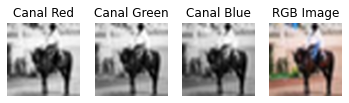

In [5]:

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#
# Visualização das Imagens
#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Obtem Imagem e seus canais
amostra_imagem = np.array(dados_amostras[indice_imagem])
amostra_imagem_red = amostra_imagem[0:1024]
amostra_imagem_green = amostra_imagem[1024:2048]
amostra_imagem_blue = amostra_imagem[2048:]

# Dimensionaliza a imagem. De um vetor n = 1024 passar para uma matriz n= 32 e m = 32.
amostra_imagem_red.shape = (32,32)
amostra_imagem_green.shape = (32,32)
amostra_imagem_blue.shape = (32,32)

# Unifica os canais obtendo a imagem em RGB.
amostra_imagem_cor = np.dstack((amostra_imagem_red, amostra_imagem_green, amostra_imagem_blue))

# Visualiza os canais e a imagem RGB.

fig = plt.figure()

a=fig.add_subplot(1,4,1)
imgplot = plt.imshow(amostra_imagem_red, interpolation='spline36', cmap='gray')
a.set_title("Canal Red")
plt.axis('off')

a=fig.add_subplot(1,4,2)
imgplot = plt.imshow(amostra_imagem_green, interpolation='spline36', cmap='gray')
a.set_title("Canal Green")
plt.axis('off')

a=fig.add_subplot(1,4,3)
imgplot = plt.imshow(amostra_imagem_blue, interpolation='spline36', cmap='gray')
a.set_title("Canal Blue")
plt.axis('off')

a=fig.add_subplot(1,4,4)
imgplot = plt.imshow(amostra_imagem_cor, interpolation='spline36')
a.set_title("RGB Image")
plt.axis('off')

plt.show()

Número de imagens: 50000


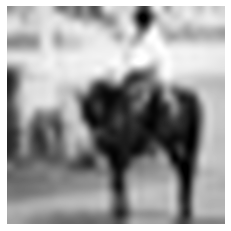

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#
# Pré-Processamento / Tratamento dos dados
#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Níveis de Cinza
# Média Ponderada: 0.3R + 0.59G + 0.11B

nro_imagens = np.size(dados_amostras[:,1])
print("Número de imagens: %d" % nro_imagens)

dados_amostras_cinza = np.zeros((nro_imagens, 1024), dtype=np.uint8)

for i in range (0, nro_imagens):    
    for j in range (0, 1024):       
                
        dados_amostras_cinza[i][j] = int((0.3 * dados_amostras[i][j]) + (0.59 * dados_amostras[i][j + 1024]) + (0.11 * dados_amostras[i][j + 2048]))

amostra_imagem = dados_amostras_cinza[indice_imagem,:]
amostra_imagem.shape = (32,32)  
imgplot = plt.imshow(amostra_imagem, interpolation='spline36', cmap='gray')
plt.axis('off')
plt.show()


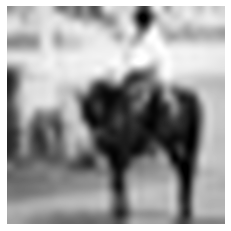

In [7]:

# Normalização -> pixel/255

dados_amostras_norm = dados_amostras_cinza / 255;

amostra_imagem = dados_amostras_norm[indice_imagem]
amostra_imagem.shape = (32,32)
imgplot = plt.imshow(amostra_imagem, interpolation='spline36', cmap='gray')
plt.axis('off')
plt.show()

In [8]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#
# Divisão dos Dados
#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

data_train_features, data_valid, data_train_target, data_valid_target = train_test_split(dados_amostras_norm, dados_target, test_size=0.2, random_state=1)

print(data_train_features.shape, data_valid.shape, data_train_target.shape, data_valid_target.shape)


(40000, 1024) (10000, 1024) (40000,) (10000,)




** REDE NEURAL **


Sigmóide: $y = \frac{1}{1 + e^{-x}}$

Derivada: $y' = \frac{e^{-x}}{(1 + e^{-x}){^2}}$

Função Custo: 


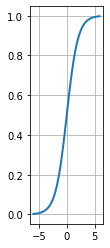

In [9]:
# Plotar as funções sigmóide

def sigmoid(z):
        return 1 / (1 + np.exp(-z))

fig = plt.figure()

testInput = np.arange(-6, 6, 0.1)
a=fig.add_subplot(1,4,3)
plt.plot(testInput, sigmoid(testInput), linewidth= 2)
plt.grid(1)

plt.show()



Entendendo uma RN

Um RN neural pode ser entendida como uma multiplicação de matriz. O Código a seguir faz uso dessa característica para realizar o foward da RN.

A playlist a seguir ajuda nessa explicação:

https://www.youtube.com/playlist?list=PLiaHhY2iBX9hdHaRr6b7XevZtgZRa1PoU

In [1]:
class NN_1HL(object):

    # Method TNC uses a truncated Newton algorithm to minimize a function with variables subject to bounds.
    # This algorithm uses gradient information; it is also called Newton Conjugate-Gradient. 
    # It differs from the Newton-CG method described above as it wraps a C implementation and allows each variable 
    # to be given upper and lower bounds.
    # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.minimize.html
    # https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf
    def __init__(self, reg_lambda=0, epsilon_init=0.12, hidden_layer_size=25, opti_method='TNC', maxiter=500):
        
        self.hidden_layer_size = hidden_layer_size
        self.activation_func = self.sigmoid
        self.activation_func_prime = self.sigmoid_prime
        self.maxiter = maxiter
        self.method = opti_method
        self.reg_lambda = reg_lambda 
        self.decai_func_custo = np.ones(maxiter)
        self.nro_iter = 0        
        self.epsilon_init = epsilon_init 
        

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_prime(self, z):
        
        sig = self.sigmoid(z)
        return sig * (1 - sig)        

    def sumsqr(self, a):
        return np.sum(a ** 2)

    def rand_init(self, l_in, l_out):
        
        
        # Cria um array com amostras aleatórias para uma distribuição uniforme de [0,1]
        # Uniform Distribution -> Retrato de muitos casos. Serão gerados valores distintos, mas com grande
        # concentração nas proximidades do valor 0.5. Logo, se o problema segue a distribuição normal para tethas,
        # e provavelmente segue, a grande maioria dos tethas são iniciados muito próximo do valore ideal. Ficando um 
        # número muito reduzido de possibilidades de um pior caso, como por exemplo o tetha foi iniciado próximo a 0 
        # e seu valor ideal é próximo a 1.
        
        # O epsilon_init transfere a distribuição para as proximidades da origem, ou seja, os tethas serão pequenos
        # valores, próximos a zero, positivos ou negativos.
        
        self.epsilon_init = (math.sqrt(6))/(math.sqrt(l_in + l_out))        
        result = np.random.rand(l_out, l_in + 1) * 2 * self.epsilon_init - self.epsilon_init

        return result

    def pack_thetas(self, t1, t2):
        return np.concatenate((t1.reshape(-1), t2.reshape(-1)))

    def unpack_thetas(self, thetas, input_layer_size, hidden_layer_size, num_labels):
        t1_start = 0
        t1_end = hidden_layer_size * (input_layer_size + 1)
        t1 = thetas[t1_start:t1_end].reshape((hidden_layer_size, input_layer_size + 1))
        t2 = thetas[t1_end:].reshape((num_labels, hidden_layer_size + 1))
        return t1, t2

    def _forward(self, X, t1, t2):
        
        m = X.shape[0]
        ones = None
        if len(X.shape) == 1:
            ones = np.array(1).reshape(1,)
        else:
            ones = np.ones(m).reshape(m,1)

        # Input layer
        # np.hstack -> Take a sequence of arrays and stack them horizontally to make a single array
        # ones -> O Bias é colocado como uma nova feature para cada amostra, o valor dessa feature 'fake' é 1, logo
        # Apenas o peso (que será aprendido) importará.
        a1 = np.hstack((ones, X))

        # Hidden Layer
        #np.dot(matA, matB) = [a11*b11 + a12*b12 + a13*b13, a21*b21 + a22*b22 + a23*b23 ...]
        z2 = np.dot(t1, a1.T)
        a2 = self.activation_func(z2)
        a2 = np.hstack((ones, a2.T))

        # Output layer
        z3 = np.dot(t2, a2.T)
        a3 = self.activation_func(z3)
        
        return a1, z2, a2, z3, a3

    #Função Custo
    def function(self, thetas, input_layer_size, hidden_layer_size, num_labels, X, y, reg_lambda):
        t1, t2 = self.unpack_thetas(thetas, input_layer_size, hidden_layer_size, num_labels)

        m = X.shape[0]
        
        # np.eye -> Matriz identidade. 
        # Y -> Matriz alvo das classes. 1 apenas para a classe verdadeira, 0 para as demais.        
        # Aprendizado supervisionado (interessante por no relatório, pq faz parte da disciplina)
        Y = np.eye(num_labels)[y]
        
        _, _, _, _, h = self._forward(X, t1, t2)
        
        # Custo positivo -> Custo da classes esperada
        # Y = 0 para classes não esperadas, logo zera o custo positivo, não influencia o custo positivo.
        
        # Esperado h = 1 -> log(1) = 0. 100% para a classe veradeira significa que o custo positivo é zero.
        # ln(x) < 0, para x E [0, 1] -> A Imagem da sigmóide é [0, 1].
        # Logo o costPositive necessita do (-) para se tornar positivo.
        costPositive = -Y * np.log(h).T        
        
        
        # Custo negativo -> Custo das classes que não são a esperada.
        # Y = 1 para a classe esperada, logo zera o custo negativo, não influencia o custo negativo.
        # Esperado h = 0 -> log(1 - 0) = 0. 0% para classe falsa significa que o custo negativo é zero.
        # matA * matB = [a1*b1, a2*b2, a3*b3 ...]
        # O costNegative será negativo        
        costNegative = (1 - Y) * np.log(1 - h).T 
        
        # cost será a soma dos módulos dos custos positivo e negativo.
        # Assim o cost será sempre positivo
        cost = costPositive - costNegative
        
        # -> Média do custo
        J = np.sum(cost) / m # -> Média do custo

        if reg_lambda != 0:
            t1f = t1[:, 1:]
            t2f = t2[:, 1:]
            reg = (self.reg_lambda / (2 * m)) * (self.sumsqr(t1f) + self.sumsqr(t2f))
            J = J + reg
        
        self.decai_func_custo[self.nro_iter] = J
        self.nro_iter = self.nro_iter + 1
        return J

    #Backpropagation
    def function_prime(self, thetas, input_layer_size, hidden_layer_size, num_labels, X, y, reg_lambda):
        
        t1, t2 = self.unpack_thetas(thetas, input_layer_size, hidden_layer_size, num_labels)

        m = X.shape[0]
        
        # Elimina as primeiras colunas, o peso do bias
        t1f = t1[:, 1:]
        t2f = t2[:, 1:]
        
        Y = np.eye(num_labels)[y]

        Delta1, Delta2 = 0, 0
        
        for i, row in enumerate(X):
            
            # Propaga para cadas amostra.
            a1, z2, a2, z3, a3 = self._forward(row, t1, t2)
            
            # Diferença entre o resultado esperado e o obtido. É o erro da camada de saída. 
            d3 = a3 - Y[i, :].T 
            
            # Multiplico o erro pelos pesos. E multiplico pela derivada da sigmóide (Mas, pq z2?)
            # Erro da camada oculta é:
            # erro da camada l = pesos da camada l 'matrix multiplication' erro camada (l + 1) vezes
            # a derivada da função de ativação da camada l.
            # Segundo regra da cadeia.
            # np.dot(t2f.T, d3) -> residual, devivada da equação linear, direção da descida.
            d2 = np.dot(t2f.T, d3) * self.activation_func_prime(z2)
            
            # The newaxis object can be used in all slicing operations to create an axis of length one. 
            # newaxis is an alias for ‘None’, and ‘None’ can be used in place of this with the same result.
            # d3 é o erro para cada classe
            # a2 é cada 'feature', ou saída de neurônio.
            # d3 . a2 -> Matriz com cada 'feature' * erro.
            # O Delta a ser utilizado no gradiente é a somatória do erro da camada seguinte mutiplicado 
            # pelo valor de saída da camada atual.
            Delta2 += np.dot(d3[np.newaxis].T, a2[np.newaxis])
            Delta1 += np.dot(d2[np.newaxis].T, a1[np.newaxis])

        # O gradiente a ser utilizado na minimização do erro.
        Theta1_grad = (1 / m) * Delta1
        Theta2_grad = (1 / m) * Delta2
        
        if reg_lambda != 0:
            Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (reg_lambda / m) * t1f
            Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (reg_lambda / m) * t2f
        
        return self.pack_thetas(Theta1_grad, Theta2_grad)

    def fit(self, X, y):
        num_features = X.shape[0]
        input_layer_size = X.shape[1]
        num_labels = len(set(y))

        theta1_0 = self.rand_init(input_layer_size, self.hidden_layer_size)
        theta2_0 = self.rand_init(self.hidden_layer_size, num_labels)
        thetas0 = self.pack_thetas(theta1_0, theta2_0)

        options = {'maxiter': self.maxiter}
        _res = optimize.minimize(self.function, thetas0, jac=self.function_prime, method=self.method, 
                                 args=(input_layer_size, self.hidden_layer_size, num_labels, X, y, 0), options=options)

        self.t1, self.t2 = self.unpack_thetas(_res.x, input_layer_size, self.hidden_layer_size, num_labels)

        np.savetxt("checkpoint/weights_t1.txt", self.t1, newline="\n")
        np.savetxt("checkpoint/weights_t2.txt", self.t2, newline="\n")

    def predict(self, X):
        return self.predict_proba(X).argmax(0)

    def predict_proba(self, X):
        _, _, _, _, h = self._forward(X, self.t1, self.t2)
        return h




In [11]:

#Dados
X_train = data_train_features[:100,:]
y_train = data_train_target[:100]
    
X_valid = data_valid
y_valid = data_valid_target


# Avaliação

In [12]:

nn = NN_1HL()
nn.fit(X_train, y_train)

print("Accuracy of classification: "+str(accuracy_score(y_valid, nn.predict(X_valid))))

<ipython-input-10-22e1eea242dc>:83: RuntimeWarning: divide by zero encountered in log
  costNegative = (1 - Y) * np.log(1 - h).T
<ipython-input-10-22e1eea242dc>:83: RuntimeWarning: invalid value encountered in multiply
  costNegative = (1 - Y) * np.log(1 - h).T


Accuracy of classification: 0.1752


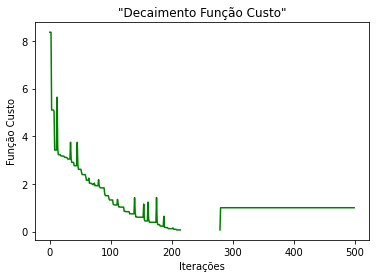

In [13]:
# Decaímento Função Custo

plt.ylabel('Função Custo')
plt.xlabel('Iterações')
plt.title('"Decaimento Função Custo"')
plt.plot( nn.decai_func_custo, 'g')

plt.show()


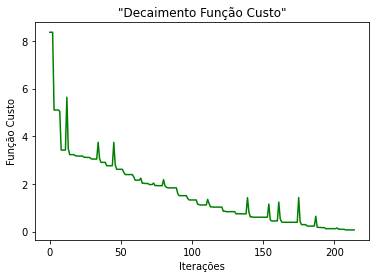

In [14]:
# Decaímento Função Custo

plt.ylabel('Função Custo')
plt.xlabel('Iterações')
plt.title('"Decaimento Função Custo"')
plt.plot( nn.decai_func_custo[:250], 'g')

plt.show()

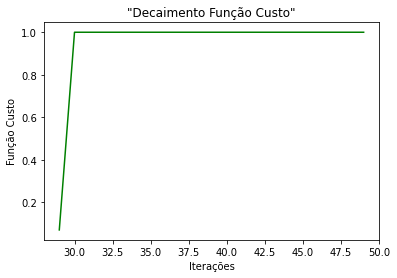

In [15]:
# Decaímento Função Custo

plt.ylabel('Função Custo')
plt.xlabel('Iterações')
plt.title('"Decaimento Função Custo"')
plt.plot( nn.decai_func_custo[250:300], 'g')

plt.show()

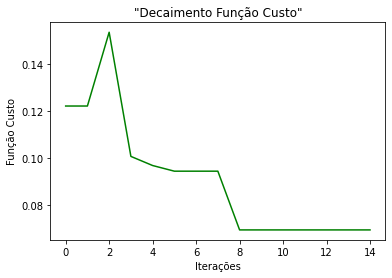

In [16]:
# Decaímento Função Custo

plt.ylabel('Função Custo')
plt.xlabel('Iterações')
plt.title('"Decaimento Função Custo"')
plt.plot( nn.decai_func_custo[200:250], 'g')

plt.show()

In [17]:

confusion =confusion_matrix(y_valid, nn.predict(X_valid))
print(confusion)


[[258  80  73  74  19  53  46  42 255  86]
 [ 43 189  75 141  81  24  33  97 165 138]
 [288  63 108 131  31  62  53  63 169  70]
 [104  52 107 188  43 123  95  79 120  78]
 [200  47  77 150  59  78 127  70 138  61]
 [ 90  83  84 177  42 154  84  81 125  75]
 [178  56  79 133  50  64  94  79 179  75]
 [131  75 127 200  40  61  96  83 112  87]
 [ 45 124  84 106  20  64  35  29 410  61]
 [ 40 214  89 118  49  19   8  76 200 209]]


In [18]:

# Provas de Conceito

# np.random.rand(l_out, l_in + 1) * 2 * self.epsilon_init - self.epsilon_init

result = 2 * 3 - 1
result2 = 2 * (3 - 1)
result3 = (2 * 3) - 1

print(result)
print(result2)
print(result3)


5
4
5


## 